In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None

In [2]:
df = pd.read_csv('ai4i2020.csv')

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [5]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
print(df['Machine failure'].unique())
print(df['OSF'].unique())
print(df['TWF'].unique())
print(df['HDF'].unique())
print(df['PWF'].unique())
print(df['RNF'].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


## Model 1: Failure Prediction

### Select features and target

In [8]:
target_col = 'Machine failure'
drop_cols = ['UDI', 'Product ID']
X = df.drop(columns=drop_cols + [target_col], errors='ignore')
y = df[target_col].astype(int)

### Identify column types

In [9]:
numeric_features = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

### Build preprocessor

In [10]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

### Train/test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Logistic Regression: Precision-Recall

In [12]:
clf = Pipeline([('pre', preprocessor), ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))])
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)[:, 1]

In [13]:
prec_lr = precision_score(y_test, preds)
rec_lr = recall_score(y_test, preds)
f1_lr = f1_score(y_test, preds)
ap_lr = average_precision_score(y_test, probas)

### Random Forest: Precision-Recall

In [14]:
rf = Pipeline([('pre', preprocessor), ('model', RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced'))])
rf.fit(X_train, y_train)
preds_rf = rf.predict(X_test)
probas_rf = rf.predict_proba(X_test)[:, 1]

In [15]:
prec_rf = precision_score(y_test, preds_rf)
rec_rf = recall_score(y_test, preds_rf)
f1_rf = f1_score(y_test, preds_rf)
ap_rf = average_precision_score(y_test, probas_rf)

### Gradient Boosting: Precision-Recall

In [16]:
gb = Pipeline([('pre', preprocessor), ('model', GradientBoostingClassifier(random_state=42))])
gb.fit(X_train, y_train)
preds_gb = gb.predict(X_test)
probas_gb = gb.predict_proba(X_test)[:, 1]

In [17]:
prec_gb = precision_score(y_test, preds_gb)
rec_gb = recall_score(y_test, preds_gb)
f1_gb = f1_score(y_test, preds_gb)
ap_gb = average_precision_score(y_test, probas_gb)

### Precision-Recall

In [18]:
import pandas as pd
summary = pd.DataFrame([
    {'Model': 'Logistic Regression', 'Recall': rec_lr, 'Precision': prec_lr, 'F1': f1_lr, 'Average Precision': ap_lr},
    {'Model': 'Random Forest', 'Recall': rec_rf, 'Precision': prec_rf, 'F1': f1_rf, 'Average Precision': ap_rf},
    {'Model': 'Gradient Boosting', 'Recall': rec_gb, 'Precision': prec_gb, 'F1': f1_gb, 'Average Precision': ap_gb},
])
summary = summary.sort_values('Recall', ascending=False).round(4)
summary

,Model,Recall,Precision,F1,Average Precision
0,Logistic Regression,0.9706,1.0,0.9851,0.9716
1,Random Forest,0.9706,1.0,0.9851,0.9796
2,Gradient Boosting,0.9706,1.0,0.9851,0.9746


## Model 2: Failure Type Classification

### Select features and target

In [19]:
failure_cols = ['TWF','HDF','PWF','OSF','RNF']
df_fail = df[df['Machine failure'] == 1].copy()
df_fail['failure_type'] = df_fail[failure_cols].idxmax(axis=1).replace({'TWF':'Tool Wear Failure','HDF':'Heat Dissipation Failure','PWF':'Power Failure','OSF':'Overstrain Failure','RNF':'Random Failure'})
X2 = df_fail.drop(columns=['failure_type','UDI','Product ID'] + failure_cols + ['Machine failure'], errors='ignore')
y2 = df_fail['failure_type']

### Identify column types

In [20]:
num2 = X2.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
cat2 = X2.select_dtypes(include=['object','category','bool']).columns.tolist()

### Build preprocessor

In [21]:
pre2 = ColumnTransformer([
    ('num', StandardScaler(), num2),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat2)
])

### Train/test split

In [22]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

### Decision Tree

In [23]:
dt = Pipeline([('pre', pre2), ('model', DecisionTreeClassifier(random_state=42))])
dt.fit(X2_train, y2_train)
preds_dt = dt.predict(X2_test)

### SVM

In [24]:
svm = Pipeline([('pre', pre2), ('model', SVC(kernel='rbf', probability=True, random_state=42))])
svm.fit(X2_train, y2_train)
preds_svm = svm.predict(X2_test)

### Naive Bayes

In [25]:
nb = Pipeline([('pre', pre2), ('model', GaussianNB())])
nb.fit(X2_train, y2_train)
preds_nb = nb.predict(X2_test)

### XGBoost

In [26]:
classes = sorted(y2.unique())
label_to_idx = {lbl: i for i, lbl in enumerate(classes)}
classes_map = {i: lbl for i, lbl in enumerate(classes)}

y2_train_enc = y2_train.map(label_to_idx).astype(int)
y2_test_enc = y2_test.map(label_to_idx).astype(int)

xgb = Pipeline([('pre', pre2), ('model', XGBClassifier(objective='multi:softprob', num_class=len(classes), random_state=42, eval_metric='mlogloss'))])
xgb.fit(X2_train, y2_train_enc)
preds_xgb = xgb.predict(X2_test)
preds_xgb_labels = pd.Series(preds_xgb).map(classes_map)

### Summary (Failure Type)

In [27]:
import numpy as np
labels_order = classes

cm_dt = confusion_matrix(y2_test, preds_dt, labels=labels_order)
f1_dt = f1_score(y2_test, preds_dt, labels=labels_order, average=None, zero_division=0)

cm_svm = confusion_matrix(y2_test, preds_svm, labels=labels_order)
f1_svm = f1_score(y2_test, preds_svm, labels=labels_order, average=None, zero_division=0)

cm_nb = confusion_matrix(y2_test, preds_nb, labels=labels_order)
f1_nb = f1_score(y2_test, preds_nb, labels=labels_order, average=None, zero_division=0)

preds_xgb_eval = preds_xgb_labels.values
cm_xgb = confusion_matrix(y2_test, preds_xgb_eval, labels=labels_order)
f1_xgb = f1_score(y2_test, preds_xgb_eval, labels=labels_order, average=None, zero_division=0)

summary2 = pd.DataFrame({
    'Model': ['Decision Tree', 'SVM', 'Naive Bayes', 'XGBoost'],
    **{f'F1 ({lbl})': [f1_dt[i], f1_svm[i], f1_nb[i], f1_xgb[i]] for i, lbl in enumerate(labels_order)}
})
summary2

,Model,F1 (Heat Dissipation Failure),F1 (Overstrain Failure),F1 (Power Failure),F1 (Tool Wear Failure)
0,Decision Tree,0.901961,0.785714,0.914286,0.818182
1,SVM,0.867925,0.764706,0.800000,0.842105
2,Naive Bayes,0.823529,0.742857,0.733333,0.700000
3,XGBoost,0.901961,0.714286,0.944444,0.857143


### Confusion Matrices (Failure Type)

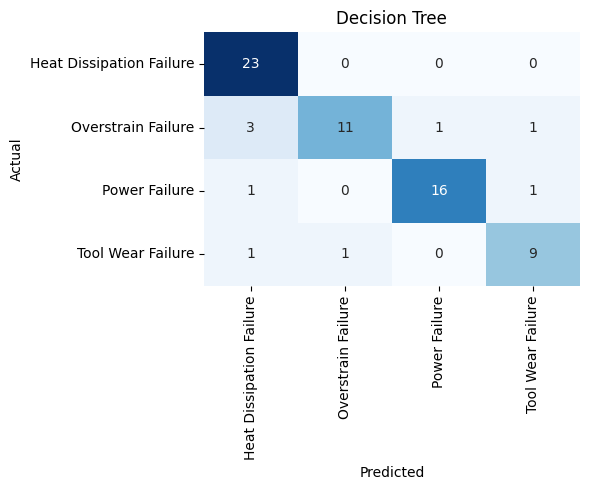

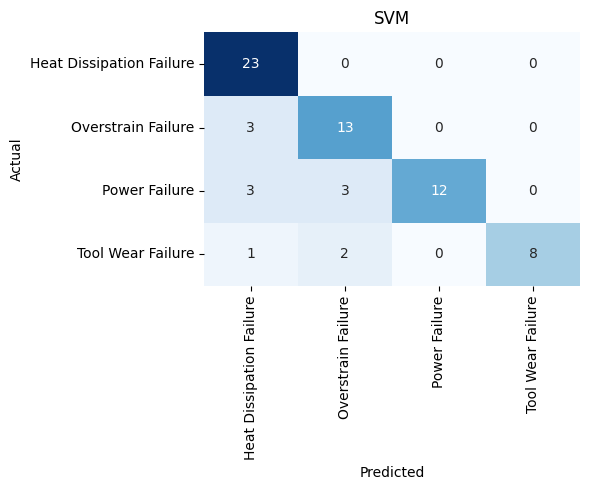

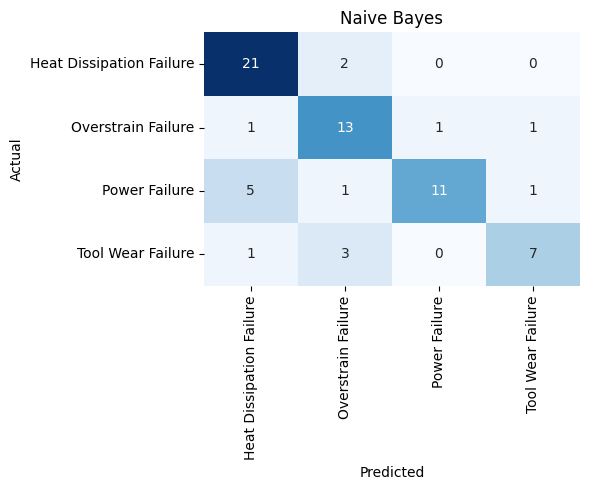

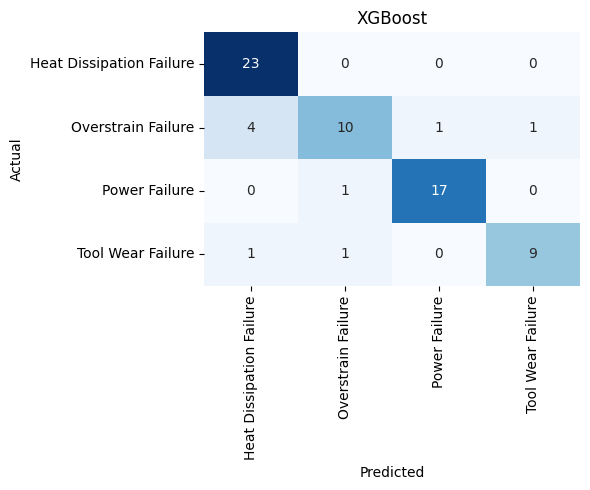

In [28]:
cms = {
    'Decision Tree': cm_dt,
    'SVM': cm_svm,
    'Naive Bayes': cm_nb,
    'XGBoost': cm_xgb,
}

for name, cm in cms.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels_order, yticklabels=labels_order)
    plt.title(name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()